# Optimization of the original letter frequencies program
Here we explore the data created by our benchmark. So first we will read the CSV file generated by our benchmark.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read the time data
data = pd.read_csv('../time_data/multiple_run_real_times.csv')
data

,init,tally,print
0,0.0929,39.0876,2.6650
1,0.1007,40.2549,2.4534
2,0.1018,39.2455,2.5838
3,0.0912,39.0448,2.4500
4,0.1147,39.1734,2.5828
...,...,...,...
495,0.0739,40.3031,2.7497
496,0.0664,39.1720,2.7052
497,0.0684,39.1562,2.5760
498,0.0619,39.8054,2.7148


## Explore the data

In [3]:
data.shape

(500, 3)

In [4]:
data.describe()

,init,tally,print
count,500.000000,500.000000,500.000000
mean,0.105415,39.932451,2.716147
std,0.463613,1.277004,0.383040
min,0.056300,39.005500,2.047200
25%,0.070675,39.220900,2.582875
50%,0.084550,39.452850,2.694450
75%,0.093400,40.195350,2.844200
max,10.443300,51.593000,9.720600


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   init    500 non-null    float64
 1   tally   500 non-null    float64
 2   print   500 non-null    float64
dtypes: float64(3)
memory usage: 11.8 KB


## Show a histogram

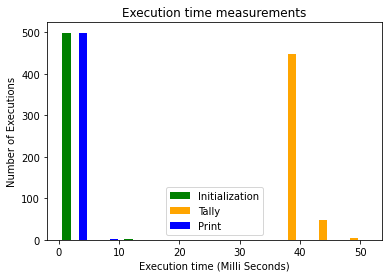

In [36]:

#data.hist()
plt.hist([data.init, data.tally, data.print], align=('mid'), color=['green', 'orange', 'blue'], label=['Initialization','Tally','Print'])
plt.title("Execution time measurements")
plt.xlabel("Execution time (Milli Seconds)")
plt.ylabel("Number of Executions")
plt.legend()

plt.show()



As it is visible from the histogram above, it's the tally algoritm that uses the most time when running the program.
To gain an understanding of how the times compare for a full execution time, we can plot the combined execution times in another histogram. 

count    500.000000
mean      42.754013
std        1.465074
min       41.417300
25%       42.020000
50%       42.300300
75%       42.864700
max       55.185700
dtype: float64


<AxesSubplot:>

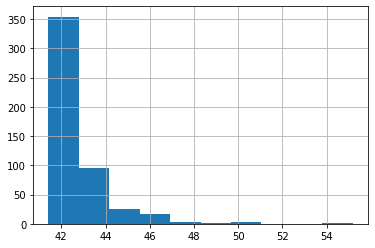

In [80]:
full_time = data.init + data.tally + data.print
print(full_time.describe())
full_time.hist()

It is now visible that most of the execution times lie around the mean, witch was calculated to (0.105415 + 39.932451 + 2.716147) = 42.754013. But theres execution times all the way up to around 54 ms. Witch is a long way from the normal runtimes.

To find out much time each part of the program is responsible for, we've plottet a pie chart of the different parts of the program. 

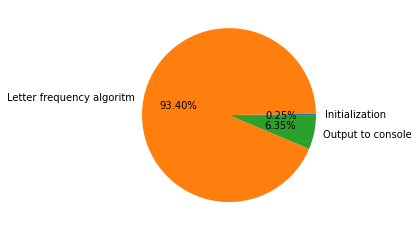

In [44]:
mean_array = [data['init'].sum(), data['tally'].sum(), data['print'].sum()]

plt.figure()
plt.pie(mean_array, labels=['Initialization', 'Letter frequency algoritm', 'Output to console'], autopct='%1.2f%%')
plt.show()

It's visible from this chart that the tally algorithm is accountable for 93.4 % of the execution time. And the output is responsible for only 6.35%. We expected the Output to console to be more expensive in total. But at the same time, this makes good sense, since the file is handle in the tally algoritm.

### Analyse runtime
Now we know that the the tally algoritm is definately where we need to keep out focus. But this we predicted beforehand. A further analysis of these charts will come, as we compare these results with the result from the optimized program. For now we know excactly where to focus our optimization.

# Boxplot
A boxplot is a great way to show benchmark results and compare them later on.

## Boxplot of the three different timings
Here is a boxplot containing all the times in three different boxes, so it's possible to compare the results. The times in the plot are not directly compareable, since they are measuring different parts of the program, it is mostly used to paint a picture of how the times are spread out and show the outliers of this perticular dataset.

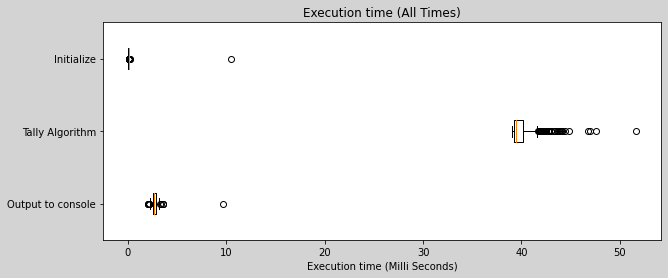

In [79]:
plt.figure(figsize=[10,4],facecolor='lightgray')
plt.boxplot(data, labels=['Initialize', 'Tally Algorithm', 'Output to console'], vert=False, positions=range(4,1,-1))
plt.title("Execution time (All Times)")
plt.xlabel("Execution time (Milli Seconds)")
plt.show()


### Initialize
The initialization is as expected very fast, and very stable. Not much fun come from analysing this until we have the optimized version to compare it to.

### Tally
The tally algorithm is by far the most time consuming during the execution of the program. It is also the part that varies the most. The tally algorithm has a std. dev. of 1.277004. Witch means that is runs in approx. 39.932451 +- 1.277004 ms. But it has the most amount of outliers, we hope to improve the stability of the algoritm as well as execution time. 

### Output to console
It's visible from the boxplot, that the output algoritm run relatively fast (around 2-3 ms). But what is interesting is the outliers with one stretching as far as 10 ms! This we need to account for when comparing to the optimized version later on.
The std. dev. is 0.383040. Witch means it doesn't vary much in execution times. This is a good thing!

# Boxplot of the Tally algoritm

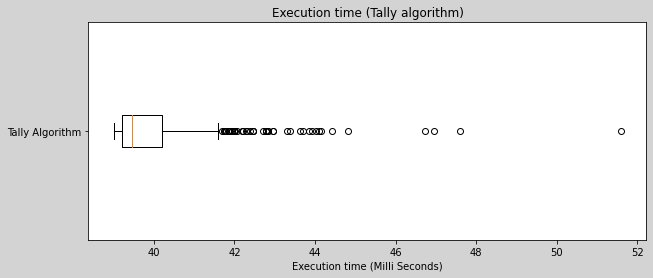

In [76]:
plt.figure(figsize=[10,4],facecolor='lightgray')
plt.boxplot(data['tally'], labels=['Tally Algorithm'], vert=False)
plt.title("Execution time (Tally algorithm)")
plt.xlabel("Execution time (Milli Seconds)")
plt.show()

This is a close up of the most time consuming part of the program. Not much new information come from this, but it is far easier to compare and read values of.

# Boxplot of the combined times
Underneath is a boxplot of the combined execution times of the 500 runs. 

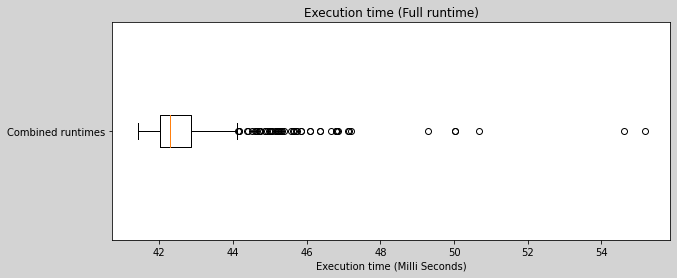

In [75]:
plt.figure(figsize=[10,4],facecolor='lightgray')
plt.boxplot(full_time, labels=['Combined runtimes'], vert=False)
plt.title("Execution time (Full runtime)")
plt.xlabel("Execution time (Milli Seconds)")
plt.show()

As it's seen in the boxplot, 50% of the runs lie between 42 and 43 millisecond with min and max steching from around 41-44.2 ms.
Again we see a plural of outliers, that we hope to bring down in our optimized solution.

In [96]:
# detecting the outliers for the three times
# Here we are finding the outliers, using the z-score

def detect_outlier(data_1):
    outliers=[]
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

outliers = detect_outlier(data.tally)
print(outliers)
data.tally.sort_values().tail(15)

[46.7305, 44.0142, 46.9461, 44.0941, 43.9271, 44.4166, 47.5907, 44.1446, 44.8155, 43.8375, 51.593]


140    43.2935
347    43.3660
132    43.6195
474    43.6940
455    43.8375
244    43.9271
63     44.0142
240    44.0941
367    44.1446
277    44.4166
413    44.8155
54     46.7305
221    46.9461
353    47.5907
485    51.5930
Name: tally, dtype: float64

In [101]:
outliers = detect_outlier(data.init)
print(outliers)
data.init.sort_values().tail(15)

[10.4433]


63      0.1315
252     0.1326
181     0.1345
224     0.1351
157     0.1400
207     0.1404
17      0.1405
287     0.1411
9       0.1426
286     0.1452
221     0.1468
77      0.1561
111     0.1889
182     0.1897
322    10.4433
Name: init, dtype: float64

In [102]:
outliers = detect_outlier(data.print)
print(outliers)
data.print.sort_values().tail(15)

[9.7206]


154    3.1066
143    3.1077
215    3.1103
250    3.1292
200    3.1681
54     3.1753
493    3.1854
195    3.1881
308    3.1927
102    3.2499
160    3.3744
62     3.5505
325    3.5676
181    3.5857
276    9.7206
Name: print, dtype: float64